In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pysam
from Bio.Seq import Seq
from Bio import SeqIO
from matplotlib.gridspec import GridSpec
from scipy.signal import savgol_filter

In [2]:
matepair_df = pd.read_csv('../KCXZ0001A_export/A_matepairs.csv', index_col=0)

In [3]:
template = SeqIO.parse('references/220416_template.fa', format='fasta')
template = str(list(template)[0].seq)
LacO_seq = 'TGTGGAATTGTGAGCGCTCACAATTCCACA'
LacO_sites = [template.find(LacO_seq), template.rfind(LacO_seq)]
CBh_start = 'gttacataacttacggtaaatggcccgcctg'
GFP_start = 'CGTACGGCCAC'
CBh_site = [template.find(CBh_start), template.find(GFP_start)]

In [4]:
transgene_ref = 'rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3'
flank_len = 840
transgene_len = 2246
end = flank_len+transgene_len

# plot coverage

In [5]:
# generate read pileup

pos_list = np.array([], dtype=int)

for i, row in matepair_df.iterrows():
    temp_list = np.array([], dtype=int)
    for x,y in zip([1,1,2,2],[1,2,1,2]):
        if row['read%i_chr%i' % (x,y)] == transgene_ref:
            temp_list = np.hstack([temp_list,np.arange(row['read%i_start%i' % (x,y)],row['read%i_end%i' % (x,y)]+1, dtype=int)])
    pos_list = np.hstack([pos_list,np.unique(temp_list)])

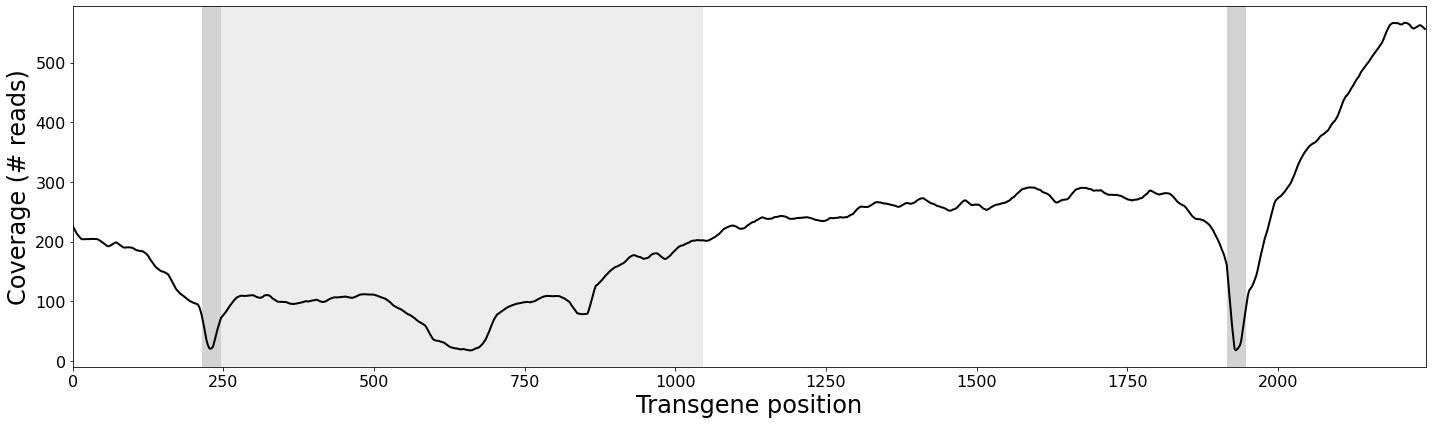

In [6]:
bins = np.arange(flank_len, end+1)
y = plt.hist(pos_list, bins=bins)
plt.close()

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.plot(range(transgene_len-1), savgol_filter(y[0][:-1],13,1), c='k', lw=2)

ax.set_xlim((0,transgene_len-1))

ax.axvspan(CBh_site[0], CBh_site[1], color='lightgray', alpha=0.4)

ax.axvspan(LacO_sites[0], LacO_sites[0]+len(LacO_seq), color='lightgray')
ax.axvspan(LacO_sites[1], LacO_sites[1]+len(LacO_seq), color='lightgray')

ax.tick_params(labelsize=16)
ax.set_ylabel('Coverage (# reads)', fontsize=24)
ax.set_xlabel('Transgene position', fontsize=24)

fig.tight_layout()
# fig.savefig('plots/transgene_coverage_A.png')
# fig.savefig('plots/transgene_coverage_A.eps')

# assess 3' junctions

In [7]:
def is_rDNA(chrom, coord):
    is_rDNA = chrom in ['rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3','NR_145819.1']
    chr13 = chrom == 'chr13' and 5770548 < coord < 9348041
    chr14 = chrom == 'chr14' and 2099537 < coord < 2817811
    chr15 = chrom == 'chr15' and 2506442 < coord < 4707485
    chr21 = chrom == 'chr21' and 3108298 < coord < 5612715
    chr22 = chrom == 'chr22' and 4793794 < coord < 5720650
    is_rDNA = is_rDNA or chr13 or chr14 or chr15 or chr21 or chr22
    return is_rDNA

In [8]:
initiationsites = np.array([], dtype=int)
initiationsites_nodup = np.array([], dtype=int)
C_P = 0
C_Im = 0
C_In = 0
I_P = 0
I_Im = 0
I_In = 0
nicksites = np.array([])
nta = np.array([])
off_target = []
gaps = []

for i, row in matepair_df.iterrows():
    CP_temp = False
    CIm_temp = False
    CIn_temp = False
    IP_temp = False
    IIm_temp = False
    IIn_temp = False
    initiationsites_temp = []
    nicksites_temp = []
    nta_temp = []
    for x in [1,2]:
        if (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (end-5) and (end+5) < row['read%i_end1' % x]) or \
        (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (end-5) and (end+5) < row['read%i_end2' % x]):
            # correct and precise
            if 'GAAAAT' in row['read%i_seq' % x] or 'ATAGCCA' in row['read%i_seq' % x]:
                CP_temp = True
                initiationsites_temp.append(end)
                nicksites_temp.append(0)
                nta_temp.append('0')
            # correct and imprecise
            elif 'GAAAGT' in row['read%i_seq' % x]:
                initiationsites_temp.append(end-1)
                nicksites_temp.append(-1)
                nta_temp.append('GAAAGT')
                CIm_temp = True
            elif 'GAAAAAGT' in row['read%i_seq' % x]:
                initiationsites_temp.append(end-1)
                nicksites_temp.append(-1)
                nta_temp.append('GAAAAAGT')
                CIm_temp = True
            elif 'GAAAAAAGT' in row['read%i_seq' % x]:
                initiationsites_temp.append(end-1)
                nicksites_temp.append(-1)
                nta_temp.append('GAAAAAAGT')
                CIm_temp = True
            elif 'GAAAAAAAAGT' in row['read%i_seq' % x]:
                initiationsites_temp.append(end-1)
                nicksites_temp.append(-1)
                nta_temp.append('GAAAAAAAAGT')
                CIm_temp = True
        elif row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == '3clipped' and \
        row['read%i_end1' % x]>(flank_len+10) and row['read%i_start1' % x]<(end-10):
            if row['read%i_end1' % x] == end: # proper initiation
                if row['read%i_chr2' % x] != '-1':
                    IP_temp = True
            elif np.abs(row['read%i_end1' % x] - end) < 4: # improper initiation
                if row['read%i_chr2' % x] != '-1':
                    IIm_temp = True
            else: # internal initiation
                if (row['read%i_chr2' % x] == transgene_ref and np.abs(row['read%i_start2' % x]-end)<5) or \
                   (row['read%i_chr2' % x] == 'NR_145819.1' and np.abs(row['read%i_start2' % x]-11698)<5):
                    CIn_temp = True
                    initiationsites_temp.append(row['read%i_end1' % x])
                elif is_rDNA(row['read%i_chr2' % x], row['read%i_start2' % x]):
                    if row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < end:
                        pass
                    else:
                        IIn_temp = True
                elif row['read%i_chr2' % x] != '-1':
                    off_target.append(row['read_ID'])

    C_P += CP_temp
    C_Im += CIm_temp
    C_In += CIn_temp
    I_P += IP_temp
    I_Im += IIm_temp
    I_In += IIn_temp
    
    initiationsites = np.hstack([initiationsites,initiationsites_temp])
    initiationsites_nodup = np.hstack([initiationsites_nodup,np.unique(initiationsites_temp)])
    nicksites = np.hstack([nicksites,np.unique(nicksites_temp)])
    nta = np.hstack([nta,np.unique(nta_temp)])

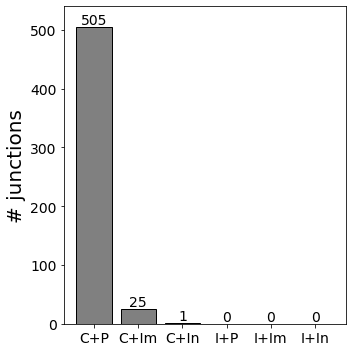

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

bars = ax.bar(np.arange(6),[C_P, C_Im, C_In, I_P, I_Im, I_In], fc='gray', ec='k')
ax.bar_label(bars, fontsize=14)
ax.set_ylim(0,540)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(['C+P','C+Im','C+In','I+P','I+Im','I+In'])
ax.tick_params(labelsize=14)
ax.set_ylabel('# junctions', fontsize=20)

fig.tight_layout()
# fig.savefig('plots/A_3junctions.eps')

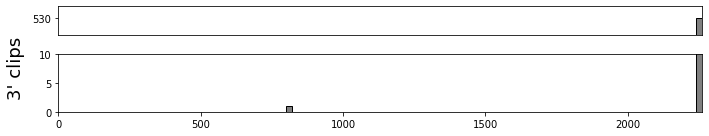

In [10]:
fig = plt.figure(figsize=(10,2))

gs = GridSpec(2, 1, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(initiationsites_nodup-840,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax1.set_ylim(527,532)
ax1.set_xlim((0,2261))
ax1.set_xticks([])
ax1.set_yticks([530])

ax2.hist(initiationsites_nodup-840,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax2.set_ylim(0,10)
ax2.set_xlim((0,2261))

fig.supylabel('3\' clips', fontsize=18)

fig.tight_layout()

# fig.savefig('plots/3truncations_A_split.eps')

In [11]:
Counter(nta)

Counter({'0': 505, 'GAAAGT': 9, 'GAAAAAGT': 7, 'GAAAAAAGT': 9})

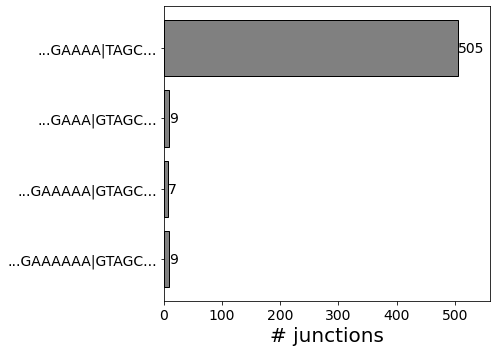

In [12]:
h = [9,7,9,505]

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

bars = ax.barh(np.arange(len(h)),h, ec='k', fc='gray')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(0,560)
# ax.set_yscale('log')

ax.set_yticks(np.arange(len(h)))
ax.set_yticklabels(['...GAAAA|TAGC...','...GAAA|GTAGC...','...GAAAAA|GTAGC...','...GAAAAAA|GTAGC...'][::-1])

ax.tick_params(labelsize=14)
ax.set_xlabel('# junctions', fontsize=20)

fig.tight_layout()
# fig.savefig('plots/3junctions_detail_A.eps')

# assess 5' junctions

In [16]:
truncations = np.array([], dtype=int)
truncations_nodup = np.array([], dtype=int)
FL_P = 0
FL_I = 0
T_P = 0
T_I = 0
indeterminate = 0
upstream_rDNA = 28
offtarget_miscellaneous = []
FLI_list = []

for i, row in matepair_df.iterrows():
    truncations_temp = []
    FLP_temp = False
    FLI_temp = False
    TP_temp = False
    TI_temp = False
    for x in [1,2]:
        # does it cross the 5' junction without duplication or deletion
        if (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (flank_len-upstream_rDNA-5) and row['read%i_end1' % x] > (flank_len+10)) or \
        (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (flank_len-upstream_rDNA-5) and row['read%i_end2' % x] > (flank_len+10)):
            FLP_temp = True
            truncations_temp.append(flank_len)
        # does it cross the 5' junction but read stops before 28 bp
        elif (row['read%i_chr1' % x] == transgene_ref and row['read%i_clipstatus1' % x] == 'fully_mapped' and \
              row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)):
            pass
        # does it cross the 5' junction but has duplication or deletion
        elif (row['read%i_chr1' % x] == transgene_ref and row['read%i_start1' % x] < (flank_len-5) and row['read%i_end1' % x] > (flank_len+10)) or \
        (row['read%i_chr2' % x] == transgene_ref and row['read%i_start2' % x] < (flank_len-5) and row['read%i_end2' % x] > (flank_len+10)):
            FLI_temp = True
            truncations_temp.append(flank_len)
        # is it truncated
        elif (row['read%i_chr2' % x] == transgene_ref and row['read%i_clipstatus2' % x] == '5clipped' and row['read%i_start2' % x] > flank_len):
            # does it join near the nick site
            if (row['read%i_chr1' % x] == transgene_ref and np.abs(row['read%i_end1' % x]-flank_len)<4) or \
            (row['read%i_chr1' % x] == 'NR_145819.1' and np.abs(row['read%i_end1' % x]-11698)<4):
                TP_temp = True
                truncations_temp.append(row['read%i_start2' % x])
                # print(row)
            # or is it alignment with a gap
            elif row['read%i_chr1' % x] == transgene_ref and row['read%i_end1' % x] > flank_len:
                offtarget_miscellaneous.append(row['read_ID'])
            # or somewhere else in rDNA
            elif is_rDNA(row['read%i_chr1' % x], row['read%i_end1' % x]):
                TI_temp = True
                # print(row)
                truncations_temp.append(row['read%i_start2' % x])
            else:
                offtarget_miscellaneous.append(row['read_ID'])

    if FLP_temp and FLI_temp:
        FLI_temp = False
    if TP_temp and TI_temp:
        TI_temp = False
    if TI_temp and FLI_temp:
        TI_temp = False
        
    if FLI_temp:
        FLI_list.append(i)
    FL_P += FLP_temp
    FL_I += FLI_temp
    T_P += TP_temp
    T_I += TI_temp
    truncations = np.hstack([truncations,truncations_temp])
    truncations_nodup = np.hstack([truncations_nodup,np.unique(truncations_temp)])

# print(FL_P, FL_I, T_P, T_I)
truncations = truncations[truncations>(flank_len-1)]
truncations_nodup = truncations_nodup[truncations_nodup>(flank_len-1)]
# print(len(truncations_nodup))

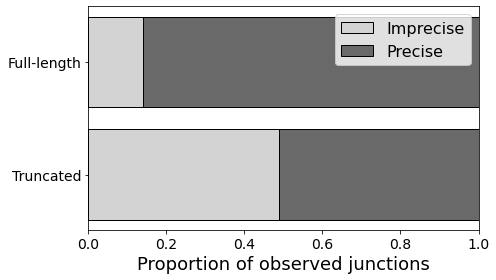

In [17]:
fig = plt.figure(figsize=(7,4))

ax = fig.add_subplot(111)
a = ax.barh(y=[1,1,0,0],width=[(FL_I-5)/(FL_I-5+FL_P),(FL_P)/(FL_I-5+FL_P),(T_I)/(T_I+T_P),(T_P)/(T_I+T_P)],
        left=[0,(FL_I-5)/(FL_I-5+FL_P),0,(T_I)/(T_I+T_P)], ec='k', color=['lightgray','dimgray'])
ax.set_yticks([0,1])
ax.set_yticklabels(['Truncated','Full-length'])
ax.tick_params(labelsize=14)
ax.set_xlabel('Proportion of observed junctions', fontsize=18)
ax.set_xlim(0,1)

ax.legend(a,['Imprecise','Precise'], fontsize=16)
fig.tight_layout()

# fig.savefig('plots/A_5junctions_percentbars.eps')
# fig.savefig('plots/A_5junctions_percentbars.png')

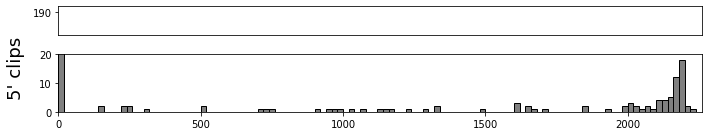

In [18]:
fig = plt.figure(figsize=(10,2))

gs = GridSpec(2, 1, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.hist(truncations_nodup-flank_len,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax1.set_ylim(182,192)
ax1.set_xlim((0,2261))
ax1.set_xticks([])
ax1.set_yticks([190])

ax2.hist(truncations_nodup-flank_len,bins=np.arange(0,2261,20), fc='gray', ec='k');
ax2.set_ylim(0,20)
ax2.set_xlim((0,2261))

fig.supylabel('5\' clips', fontsize=18)
fig.tight_layout()


# fig.savefig('plots/5truncations_A_split.eps')

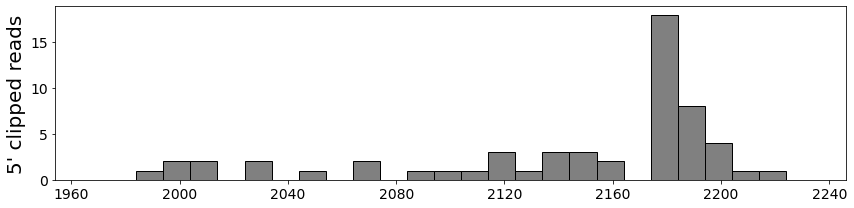

In [19]:
fig = plt.figure(figsize=(12,3))

junctions = truncations_nodup-flank_len
UTR_len = 292
bins = np.arange(transgene_len-UTR_len,transgene_len,10)

ax = fig.add_subplot(111)
ax.hist(junctions[junctions>(transgene_len-UTR_len)], bins=bins, fc='gray', ec='k')

ax.set_xlim((transgene_len-UTR_len),transgene_len)
ax.set_ylabel('5\' clipped reads', fontsize=20)
# ax.set_xlabel('Transgene position', fontsize=24)
ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(1960,2245,40))
ax.tick_params(labelsize=14)
fig.tight_layout()

# fig.savefig('plots/UTR_truncations.png', dpi=600)
# fig.savefig('plots/UTR_truncations_A.eps')

# off-target

In [354]:
matepair_df[matepair_df['read_ID']==off_target[0]]

,read_ID,read1_orientation,read2_orientation,read1_seq,read2_seq,read1_chr1,read1_start1,read1_end1,read1_loc1,read1_mapq1,...,read2_loc1,read2_mapq1,read2_clipstatus1,read2_chr2,read2_start2,read2_end2,read2_loc2,read2_mapq2,read2_clipstatus2,mate_orientation
985,A00887:430:H7GFYDSX3:4:1551:31394:23766,R,F,CAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCC...,CAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCG...,rDNA-flanked_TriCasA5_CBhBsi_GFP_GeFo3,2427,2508,0,60,...,0,60,3clipped,-1,-1,-1,-1,-1,-1,"R,F"


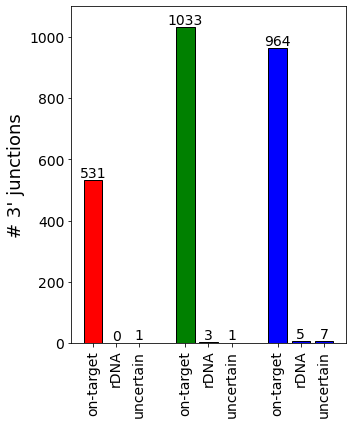

In [20]:
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)

A_target = [531,0,1]
D_target = [1033,3,1]
E_target = [964,5,7]

x = [0,1,2,4,5,6,8,9,10]
bars = ax.bar(x, A_target+D_target+E_target, color=['r']*3+['g']*3+['b']*3, ec='k')
ax.bar_label(bars, fontsize=14)
ax.set_ylabel('# 3\' junctions', fontsize=18)
ax.tick_params(labelsize=14)
ax.set_ylim(0,1100)

ax.set_xticks(x)
ax.set_xticklabels(['on-target','rDNA','uncertain']*3, rotation=90)

fig.tight_layout()
# fig.savefig('plots/offtarget_reads.eps')